In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.linear_model as lm 
import sklearn.ensemble as em 
from sklearn.svm import SVC

In [1]:
import data_clean_for_model

In [4]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [5]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 50)
np.set_printoptions(suppress=True)
rseed = 229

In [6]:
# download data 
# if you don't have these csvs, run the preprocessing notebook. 
# Ill turn this this into a py file later, but for now should be fine 
dfs = pd.read_parquet("data/all_processed_df.parquet.gzip")

In [7]:
k = 5
np.random.seed(rseed)
# add outcome var + unique id 
dfs['outcome'] = np.where(dfs['state']=="successful", 1, 0)
dfs['un_id'] = np.arange(0, dfs.shape[0], 1)
dfs['name_len'] = dfs['name'].str.len()
dfs['cv_group'] = np.random.choice(np.arange(0, k), size=dfs.shape[0])

In [8]:
dfs['cv_group'].value_counts()

2    44476
4    44335
0    44256
3    44121
1    44060
Name: cv_group, dtype: int64

In [9]:
model_params = {
    'cv': True, 
    'lnom_frac':0.3, 
    'test_frac':0.3, 
    'lnom_usdgoal':True,
    'dummies':True,
    'rseed': 229,
}

In [10]:
X_train, X_test, y_train, y_test = data_clean_for_model.data_clean_for_model(dfs, "outcome", model_params, cv=model_params['cv'])

In [12]:
# specify some model performance funcs 
def rmse(y, yhat):
    print("RMSE:", np.round(np.sqrt( np.mean( (y - yhat)**2 ) ), 3))
    
def acc(y, yhat):
    yhat_rounded = np.round(yhat)
    print("Accuracy:", np.round(np.mean(yhat_rounded == y), 3))

In [13]:
## 1. Naive approach:
# Idea: what if we just guess the outcome of previous projects within this category
naive = np.array(np.round(X_test['cat_id_outcome_mean']).reset_index(drop=True))
rmse(y_test, naive)
acc(y_test, naive)

RMSE: 0.564
Accuracy: 0.681


In [14]:
## 1.5 OLS: 
ols = lm.LinearRegression(normalize=False)
ols.fit(X_train.drop(columns=['dummy_cat_id_1','dummy_cat_parent_id_1.0']), y_train)
y_test_hat = ols.predict(X_test.drop(columns=['dummy_cat_id_1','dummy_cat_parent_id_1.0']))
rmse(y_test, y_test_hat)
acc(y_test, y_test_hat)

RMSE: 0.376
Accuracy: 0.783


In [15]:
## 2. Lasso
# Since our feature space isn't that large and also not very rich (at least in a linear sense), don't expect great results here  
clf_lasso = lm.Lasso(alpha=0.05, normalize=False, random_state=rseed)
clf_lasso.fit(X_train, y_train)
y_test_hat = clf_lasso.predict(X_test)
rmse(y_test, y_test_hat)
acc(y_test, y_test_hat)

RMSE: 0.436
Accuracy: 0.715


In [16]:
## 3. Ridge
# Similar expectations to lasso, though at least it won't kick out features from our model, so should do a bit better  

# training procedure for a cross-validated ridge, but don't think this is necessary right now 
#clf_ridgecv = lm.RidgeCV(alphas=np.arange(0.1, 1, 0.02), cv=10).fit(X_train_lnom, y_train)
#print(clf_ridgecv.alpha_)
#y_test_hat = clf_ridgecv.predict(X_test_lnom)
#rmse(y_test, y_test_hat)
#acc(y_test, y_test_hat)
# train ridge 
clf_ridge = lm.Ridge(alpha=0.95, normalize=False, random_state=rseed)
clf_ridge.fit(X_train, y_train)
y_test_hat = clf_ridge.predict(X_test)
rmse(y_test, y_test_hat)
acc(y_test, y_test_hat)

RMSE: 0.375
Accuracy: 0.784


/Users/benji/anaconda3/envs/play/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.53911e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [17]:
## 4. Logistic Reg  
# Similar expectations to lasso + ridge 
# To avoid regularization set C to be very large and/or penalty to none 
glf = lm.LogisticRegression(C=1, random_state=rseed, penalty='none')
glf.fit(X_train, y_train)
print("Coefficients:", glf.intercept_, np.round(glf.coef_, 3)) 
y_test_hat = glf.predict(X_test)
print(pd.Series(y_test_hat).value_counts())
rmse(y_test, y_test_hat)
acc(y_test, y_test_hat)

Coefficients: [-0.] [[-0.  0. -0. -0.  0. -0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0. -0. -0.
  -0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  -0. -0.  0. -0. -0. -0.  0. -0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.
  -0. -0.  0.  0.  0.  0. -0.  0.  0.  0.  0. -0. -0. -0.  0.  0. -0. -0.
  -0.  0.  0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0.  0.  0. -0. -0.
  -0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
  -0. -0. -0. -0. -0. -0. -0. -0.  0.  0. -0. -0. -0. -0. -0. -0. -0. -0.
  -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0.
  -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0.  0.
  -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
  -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0. -0.  0. -0.
  -0.  0.  0. -0.  0. -0. -0. -0.  0. -0.  0.  0.  0.  0.  0.  0.]]
1    51947
0    14428
dtype: int64
RMSE: 0.57
Accuracy: 0.675


/Users/benji/anaconda3/envs/play/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
## 6. Random Forest (cont. )
# selected optimal params from cell above
best_params = {'bootstrap': False, 'max_depth': 65, 'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 30}
# run RF 
rf = em.RandomForestClassifier(random_state=rseed, class_weight='balanced', **best_params)
rf.fit(X_train, y_train)
y_test_hat = rf.predict(X_test)
y_test_hat_proba = rf.predict_proba(X_test)
print(pd.Series(y_test_hat).value_counts())
rmse(y_test, y_test_hat)
acc(y_test, y_test_hat)

0    33537
1    32838
dtype: int64
RMSE: 0.446
Accuracy: 0.801


In [19]:
clf = lgb.LGBMClassifier(
    random_state=rseed, 
    is_unbalance=True, 
    bagging_fraction=0.5, 
    feature_fraction=1, 
    max_depth = 55, 
    max_bin = 500, 
    num_leaves = 400, 
    lambda_l1 = 0,
    lambda_l2 = 0
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
accuracy 0.8127306967984934
              precision    recall  f1-score   support

           0       0.72      0.87      0.79     26428
           1       0.90      0.78      0.83     39947

    accuracy                           0.81     66375
   macro avg       0.81      0.82      0.81     66375
weighted avg       0.83      0.81      0.81     66375

[[22901  3527]
 [ 8903 31044]]


In [20]:
# add naive bayes preds 
nb_proba_train = np.load("data/res/multi_nb_preds_train_big.npy")
nb_proba_test = np.load("data/res/multi_nb_preds_test_big.npy")
#nb_proba_train2 = np.load("data/res/multi_nb_preds_train_opt.npy")
#nb_proba_test2 = np.load("data/res/multi_nb_preds_test_opt.npy")
X_train_nb = X_train.copy()
X_test_nb = X_test.copy()
X_train_nb['nb_proba'] = nb_proba_train[:, 1]
X_test_nb['nb_proba'] = nb_proba_test[:, 1]
#X_train_nb['nb_proba2'] = nb_proba_train2[:, 1]
#X_test_nb['nb_proba2'] = nb_proba_test2[:, 1]
w2v_train = np.load("data/res/w2v_Xtrain_avg_big.npy")
w2v_test = np.load("data/res/w2v_Xtest_avg_big.npy")
X_train_nb_w2v = pd.concat((X_train_nb, pd.DataFrame(w2v_train)), axis=1)
X_test_nb_w2v = pd.concat((X_test_nb, pd.DataFrame(w2v_test)), axis=1)

In [21]:
clf = lgb.LGBMClassifier(
    random_state=rseed, 
    is_unbalance=True, 
    bagging_fraction=0.75, 
    feature_fraction=0.8, 
    max_depth = 55, 
    max_bin = 500, 
    num_leaves = 400, 
    lambda_l1 = 0,
    lambda_l2 = 0
)
clf.fit(X_train_nb, y_train)
y_pred = clf.predict(X_test_nb)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
accuracy 0.8220263653483992
              precision    recall  f1-score   support

           0       0.76      0.81      0.78     26428
           1       0.87      0.83      0.85     39947

    accuracy                           0.82     66375
   macro avg       0.81      0.82      0.82     66375
weighted avg       0.83      0.82      0.82     66375

[[21536  4892]
 [ 6921 33026]]


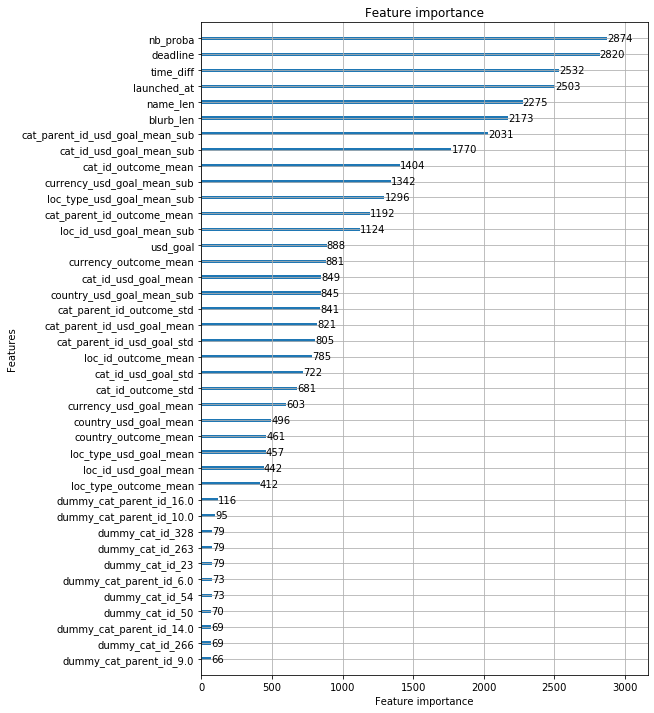

In [22]:
lgb.plot_importance(clf, max_num_features=40, figsize=(8, 12))

In [23]:
# BEST SO FAR 
drop_cols=[
    'country_outcome_mean', 'loc_id_usd_goal_mean', 'loc_type_usd_goal_mean', 'loc_type_outcome_mean'
]
clf = lgb.LGBMClassifier(
    random_state=rseed, 
    is_unbalance=True, 
    bagging_fraction=0.75, 
    feature_fraction=0.8, 
    max_depth = 55, 
    max_bin = 500, 
    num_leaves = 400, 
    lambda_l1 = 0,
    lambda_l2 = 0
)
clf.fit(X_train_nb.drop(columns=drop_cols), y_train)
y_pred = clf.predict(X_test_nb.drop(columns=drop_cols))
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
accuracy 0.8225838041431262
              precision    recall  f1-score   support

           0       0.76      0.82      0.79     26428
           1       0.87      0.83      0.85     39947

    accuracy                           0.82     66375
   macro avg       0.81      0.82      0.82     66375
weighted avg       0.83      0.82      0.82     66375

[[21571  4857]
 [ 6919 33028]]


In [24]:
clf = lgb.LGBMClassifier(
    random_state=rseed, 
    is_unbalance=True, 
    bagging_fraction=0.75, 
    feature_fraction=0.8, 
    max_depth = 55, 
    max_bin = 500, 
    num_leaves = 400, 
    lambda_l1 = 0,
    lambda_l2 = 0
)
clf.fit(X_train_nb_w2v, y_train)
y_pred = clf.predict(X_test_nb_w2v)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
accuracy 0.8150508474576271
              precision    recall  f1-score   support

           0       0.76      0.79      0.77     26428
           1       0.85      0.83      0.84     39947

    accuracy                           0.82     66375
   macro avg       0.81      0.81      0.81     66375
weighted avg       0.82      0.82      0.82     66375

[[20773  5655]
 [ 6621 33326]]


In [25]:
lda_df = pd.read_csv("data/lda_df.csv").drop(columns=['Unnamed: 0'])
lda_df_test = pd.read_csv("data/lda_df_test.csv").drop(columns=['Unnamed: 0'])
X_train_nb_lda = pd.concat((X_train_nb, lda_df), axis=1)
X_test_nb_lda = pd.concat((X_test_nb, lda_df_test), axis=1)
X_train_nb_w2v_lda = pd.concat((X_train_nb_w2v, lda_df), axis=1)
X_test_nb_w2v_lda = pd.concat((X_test_nb_w2v, lda_df_test), axis=1)

In [26]:
clf = lgb.LGBMClassifier(
    random_state=rseed, 
    is_unbalance=True, 
    bagging_fraction=0.75, 
    feature_fraction=0.2, 
    max_depth = 55, 
    max_bin = 500, 
    num_leaves = 400, 
    lambda_l1 = 0,
    lambda_l2 = 0
)
clf.fit(X_train_nb_lda, y_train)
y_pred = clf.predict(X_test_nb_lda)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
accuracy 0.824225988700565
              precision    recall  f1-score   support

           0       0.75      0.83      0.79     26428
           1       0.88      0.82      0.85     39947

    accuracy                           0.82     66375
   macro avg       0.82      0.83      0.82     66375
weighted avg       0.83      0.82      0.83     66375

[[21965  4463]
 [ 7204 32743]]


In [32]:
clf = lgb.LGBMClassifier(
    random_state=rseed, 
    is_unbalance=True, 
    bagging_fraction=0.75, 
    feature_fraction=0.8, 
    max_depth = 55, 
    max_bin = 500, 
    num_leaves = 400, 
    lambda_l1 = 0.5,
    lambda_l2 = 0
)
clf.fit(X_train_nb_w2v_lda, y_train)
y_pred = clf.predict(X_test_nb_w2v_lda)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
accuracy 0.8097777777777778
              precision    recall  f1-score   support

           0       0.74      0.80      0.77     26428
           1       0.86      0.82      0.84     39947

    accuracy                           0.81     66375
   macro avg       0.80      0.81      0.80     66375
weighted avg       0.81      0.81      0.81     66375

[[21016  5412]
 [ 7214 32733]]


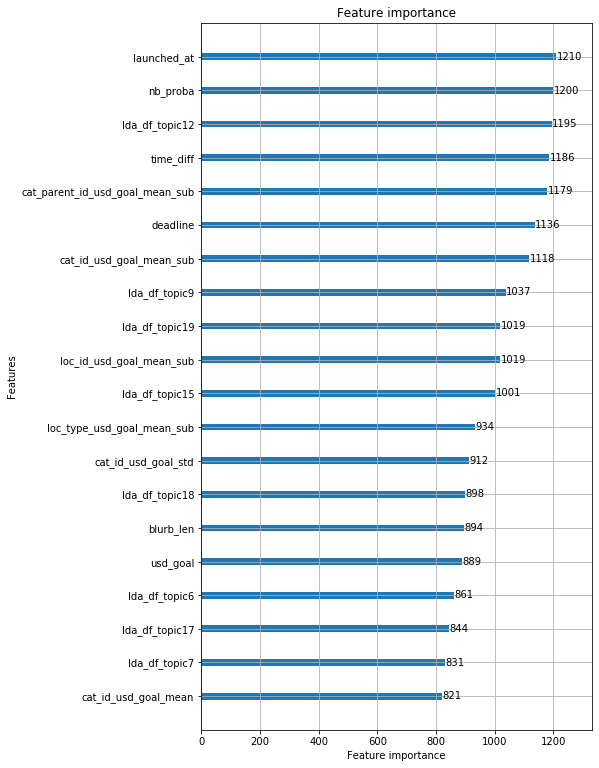

In [27]:
lgb.plot_importance(clf, max_num_features=20, figsize=(7, 13))